In [1]:
import heeps
from heeps.util.img_processing import resize_cube
from heeps.util.coord import cart_coord
import matplotlib.pyplot as plt
import os.path
from astropy.io import fits
%matplotlib inline

## Input parameters

In [2]:
npupil_L = 285
npupil_N = 119 # N2 band
nimg = 720
pupil_img_size = 39.9988
ax, ay = (-14.642, -55.812) # A0
bx, by = (  0.739, -75.899) # B2
cx, cy = (  5.691, -65.735) # C1
dx, dy = ( 15.628, -45.397) # D0
AT_rad = 1.8/2              # AT radius
AT_rot = -8.5                # AT rotation in deg
RMS_WV_L = 90
RMS_WV_N = 1000
folder = '/Users/cdelacroix/heeps_metis/input_files/wavefront'
scao = 'cube_Cbasic_20210322_6000s_100ms_0piston_meters_scao_only_%s_WVseeing.fits'%nimg
mask = 'mask_Cbasic_20210322_%s.fits'%nimg

## AT coordinates

In [3]:
# find circumcenter and translate
d = 2 * (ax * (by - dy) + bx * (dy - ay) + dx * (ay - by))
ux = ((ax**2 + ay**2) * (by - dy) + (bx**2 + by**2) * (dy - ay) + (dx**2 + dy**2) * (ay - by)) / d
uy = ((ax**2 + ay**2) * (dx - bx) + (bx**2 + by**2) * (ax - dx) + (dx**2 + dy**2) * (bx - ax)) / d
ATs = np.array([[ax, ay], [bx, by], [cx, cy], [dx, dy]]) - [ux, uy]
# rotate to fit in ELT M1
t = np.deg2rad(AT_rot)
ATs = np.array([(x*np.cos(t) - y*np.sin(t), x*np.sin(t) + y*np.cos(t)) for x,y in ATs])
print('AT coords:\n%s'%ATs)

AT coords:
[[-17.19345442   4.94727687]
 [ -4.95044907 -17.19254133]
 [  1.44949234  -7.8721363 ]
 [ 14.28349078  10.77368621]]


## Create subapertures

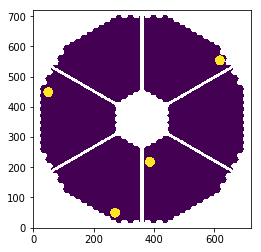

In [4]:
XY = np.array(cart_coord(nimg), ndmin=4)*pupil_img_size/2
XY = (XY.T - ATs.T).T
apers = np.abs(XY[:,0] + 1j*XY[:,1])
apers = (apers <= AT_rad).astype(int)
pup = fits.getdata(os.path.join(folder, mask))
pup[pup < .5] = np.nan
apers_ATs = np.sum(apers, 0) + pup
fits.writeto(os.path.join(folder, 'apers_ATs.fits'), np.float32(apers_ATs), overwrite=True)
plt.imshow(apers_ATs, origin=True);

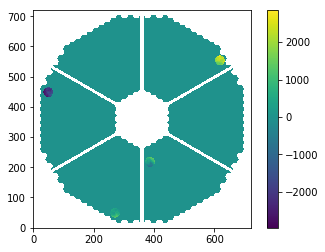

In [5]:
cube = fits.getdata(os.path.join(folder, scao))*1e9
apers_ATs_phase = np.sum(apers, 0)*cube[0] + pup
fits.writeto(os.path.join(folder, 'apers_ATs_phase.fits'), np.float32(apers_ATs_phase), overwrite=True)
plt.imshow(apers_ATs_phase, origin=True), plt.colorbar();

## Temporal RMS on MATISSE bases

temporal rms (nm) = [2335.43 2417.97 2530.35 2229.96 2541.01 2429.64]
mean temporal rms = 2414.06 nm


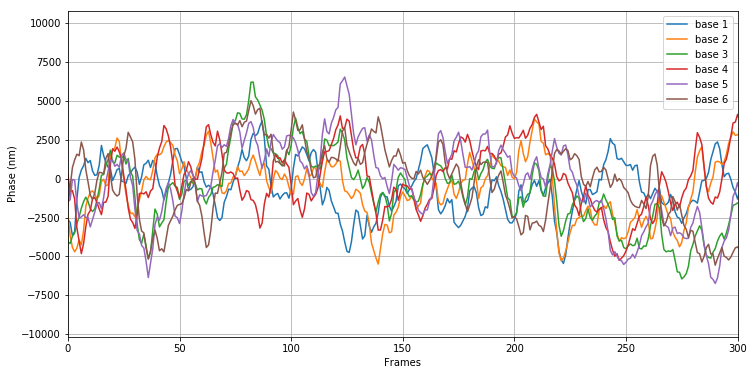

In [6]:
pistons = np.empty((len(apers), len(cube)))
for i, aper in enumerate(apers):
    pistons[i,:] = np.array([np.mean(frame[frame!=0]) for frame in aper*cube])
OPDs = np.array([pistons[0,:] -  pistons[1,:],
                 pistons[0,:] -  pistons[2,:],
                 pistons[0,:] -  pistons[3,:],
                 pistons[1,:] -  pistons[2,:],
                 pistons[1,:] -  pistons[3,:],
                 pistons[2,:] -  pistons[3,:]])
RMS = np.std(OPDs, 1)
print('temporal rms (nm) = %s\nmean temporal rms = %s nm'%(np.round(RMS, 2), np.round(np.mean(RMS), 2)))
plt.figure(figsize=(12,6))
for i, OPD in enumerate(OPDs):
    plt.plot(OPD, label='base %s'%(i+1))
plt.xlim(0,300)
plt.legend()
plt.xlabel('Frames')
plt.ylabel('Phase (nm)')
plt.grid(True), plt.grid(which='minor', linestyle=':');

## Spatial RMS

mean spatial rms = 1657.92 nm


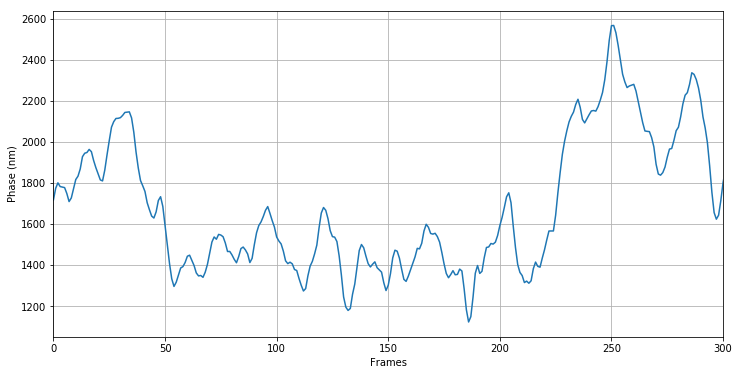

In [7]:
spatial_RMS = [np.std(x[x!=0]) for x in cube]
print('mean spatial rms = %s nm'%np.round(np.mean(spatial_RMS), 2))
plt.figure(figsize=(12,6))
plt.plot(spatial_RMS)
plt.xlim(0,300)
plt.xlabel('Frames')
plt.ylabel('Phase (nm)')
plt.grid(True), plt.grid(which='minor', linestyle=':');

## Rescaled RMS at L band

In [8]:
cube_L = cube*RMS_WV_L/np.mean(RMS)
pistons = np.empty((len(apers), len(cube_L)))
for i, aper in enumerate(apers):
    pistons[i,:] = np.array([np.mean(frame[frame!=0]) for frame in aper*cube_L])
OPDs = np.array([pistons[0,:] -  pistons[1,:],
                 pistons[0,:] -  pistons[2,:],
                 pistons[0,:] -  pistons[3,:],
                 pistons[1,:] -  pistons[2,:],
                 pistons[1,:] -  pistons[3,:],
                 pistons[2,:] -  pistons[3,:]])
RMS_L = np.std(OPDs, 1)
print('temporal rms (nm) = %s\nmean temporal rms = %s nm'%(np.round(RMS_L, 2), np.round(np.mean(RMS_L), 2)))
spatial_RMS_L = [np.std(x[x!=0]) for x in cube_L]
print('mean spatial rms = %s nm'%np.round(np.mean(spatial_RMS_L), 2))

temporal rms (nm) = [87.07 90.15 94.34 83.14 94.73 90.58]
mean temporal rms = 90.0 nm
mean spatial rms = 61.81 nm


In [9]:
# resize to npupil
cube_L = resize_cube(cube_L, npupil_L)
spatial_RMS_L = [np.std(x[x!=0]) for x in cube_L]
print('mean spatial rms = %s nm'%np.round(np.mean(spatial_RMS_L), 2))

mean spatial rms = 59.01 nm


## Rescaled RMS at N2 band

In [10]:
cube_N = cube*RMS_WV_N/np.mean(RMS)
pistons = np.empty((len(apers), len(cube_N)))
for i, aper in enumerate(apers):
    pistons[i,:] = np.array([np.mean(frame[frame!=0]) for frame in aper*cube_N])
OPDs = np.array([pistons[0,:] -  pistons[1,:],
                 pistons[0,:] -  pistons[2,:],
                 pistons[0,:] -  pistons[3,:],
                 pistons[1,:] -  pistons[2,:],
                 pistons[1,:] -  pistons[3,:],
                 pistons[2,:] -  pistons[3,:]])
RMS_N = np.std(OPDs, 1)
print('temporal rms (nm) = %s\nmean temporal rms = %s nm'%(np.round(RMS_N, 2), np.round(np.mean(RMS_N), 2)))
spatial_RMS_N = [np.std(x[x!=0]) for x in cube_N]
print('mean spatial rms = %s nm'%np.round(np.mean(spatial_RMS_N), 2))

temporal rms (nm) = [ 967.43 1001.62 1048.17  923.74 1052.59 1006.45]
mean temporal rms = 1000.0 nm
mean spatial rms = 686.78 nm


In [11]:
# resize to npupil
cube_N = resize_cube(cube_N, npupil_N)
spatial_RMS_N = [np.std(x[x!=0]) for x in cube_N]
print('mean spatial rms = %s nm'%np.round(np.mean(spatial_RMS_N), 2))

mean spatial rms = 622.0 nm
